In [ ]:
import os
import json
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# =========================
# CONFIG
# =========================
DATA_DIR = "../src/plots"
NAME_MAP_FILE = "algorithm_names.json"
target_accuracy = 0.794
dataset_name = "fashion_mnist"
total_clients = 5


# =========================
# HELPERS
# =========================
def load_dict(filepath):
    with open(filepath, "r") as f:
        content = f.read()
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            return ast.literal_eval(content)


def parse_filename(filename):
    """
    default_5_7_claudiogsc_emnist_balance
    returns:
    algo=default, clients=5, classes=7, dataset=claudiogsc_emnist_balanced
    """
    parts = filename.split("_")
    algo_name = parts[0]

    if algo_name == "default":
        return algo_name, int(parts[1]), None, "_".join(parts[3:])
    return algo_name, int(parts[1]), int(parts[2]), "_".join(parts[3:])


# =========================
# COLLECT FILES
# =========================
results_files = {}
round_time_files = {}

for file in os.listdir(DATA_DIR):
    if file.endswith("_results.json"):
        key = file.replace("_results.json", "")
        results_files[key] = os.path.join(DATA_DIR, file)
    elif file.endswith("_round_times.json"):
        key = file.replace("_round_times.json", "")
        round_time_files[key] = os.path.join(DATA_DIR, file)

common_keys = set(results_files.keys()) & set(round_time_files.keys())

# =========================
# PROCESS DATA
# =========================
algo_data = {}

for key in common_keys:
    algo, clients, classes, dataset = parse_filename(key)

    if dataset != dataset_name or clients != total_clients or algo == "default":
        continue

    unique_algo_key = f"{algo}_{classes}"

    results = load_dict(results_files[key])
    times = load_dict(round_time_files[key])

    round_acc = defaultdict(list)

    for client_id, rounds in results.items():
        for rnd, data in rounds.items():
            round_acc[int(rnd)].append(data["metrics"]["accuracy"])

    rounds_sorted = sorted(round_acc.keys())

    avg_accuracy = []
    avg_time = []
    cumulative_time = 0
    final_round = 0
    for rnd in rounds_sorted:
        avg_accu = np.mean(round_acc[rnd])
        final_round = rnd

        if rnd > 100:
            break

        avg_accuracy.append(avg_accu)
        cumulative_time += times[str(rnd)]
        avg_time.append(cumulative_time)

    algo_data[unique_algo_key] = {
        "algo": algo,
        "clients": clients,
        "classes": classes,
        "final_round": final_round,
        "accuracy": np.array(avg_accuracy),
        "time": np.array(avg_time),
    }

Processed HFedCVAE_8: final round 100, final accuracy 0.8164, total time 847.04s
Processed HFedCVAEGAN_3: final round 100, final accuracy 0.8321, total time 891.87s
Processed HFedCVAE_10: final round 100, final accuracy 0.8085, total time 878.67s
Processed HFedCVAE_5: final round 100, final accuracy 0.8071, total time 887.95s
Processed HFedCGAN_10: final round 100, final accuracy 0.7315, total time 871.38s
Processed HFedCGAN_1: final round 100, final accuracy 0.7597, total time 845.43s
Processed HFedCVAEGAN_10: final round 100, final accuracy 0.8062, total time 881.88s
Processed HFedCVAE_9: final round 100, final accuracy 0.8172, total time 855.94s
Processed HFedCGAN_3: final round 100, final accuracy 0.7598, total time 825.45s
Processed HFedCGAN_2: final round 100, final accuracy 0.7564, total time 842.80s
Processed HFedCVAEGAN_9: final round 100, final accuracy 0.8114, total time 950.75s
Processed HFedCGAN_6: final round 100, final accuracy 0.7655, total time 862.71s
Processed HFedCV

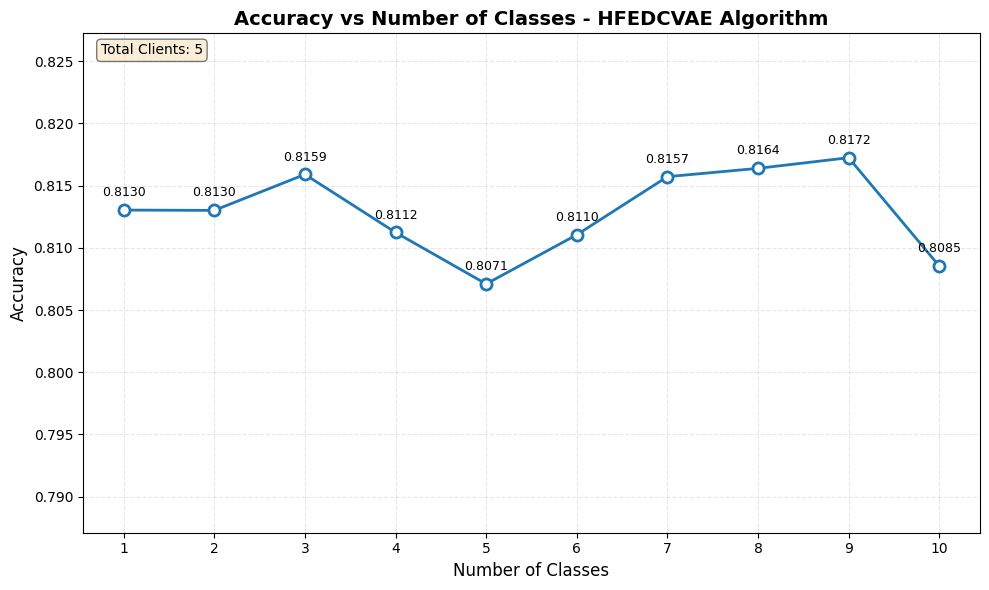

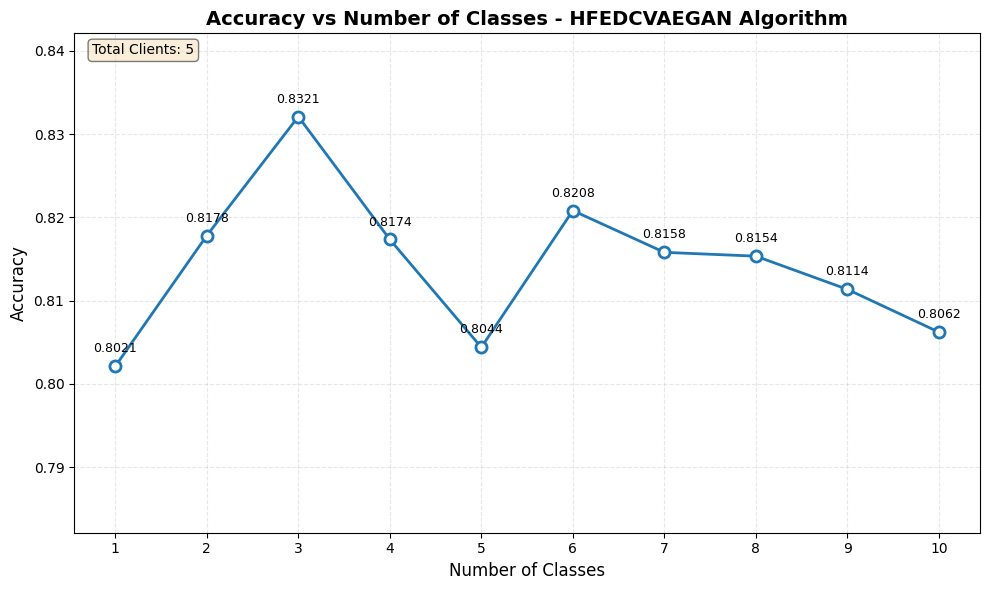

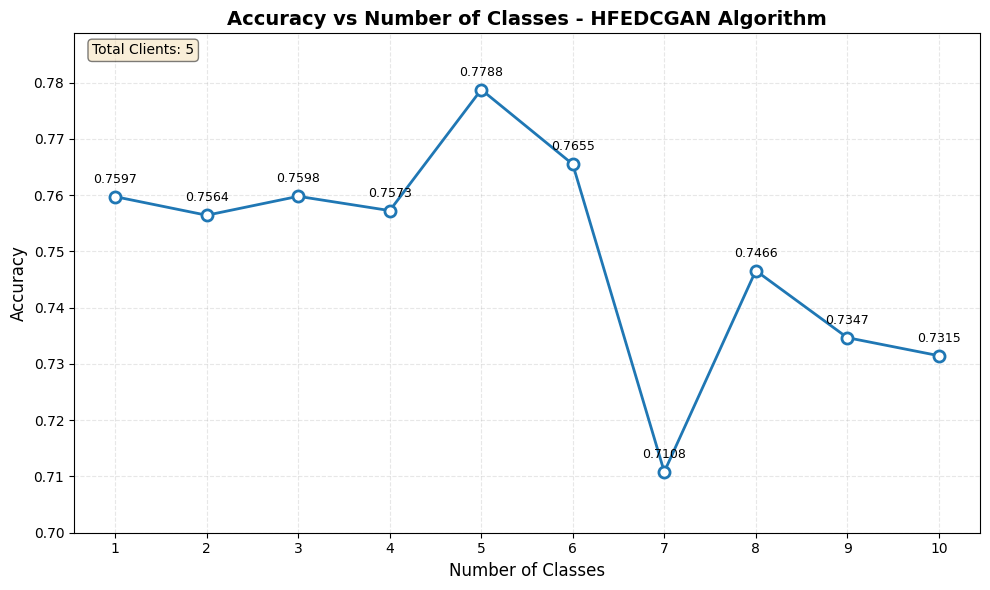

In [6]:
# Group data by algorithm
algo_groups = defaultdict(list)

for key, data in algo_data.items():
    algo_groups[data["algo"]].append(data)

# Sort each group by number of classes
for algo in algo_groups:
    algo_groups[algo].sort(key=lambda x: x["classes"])

# Create a separate figure for each algorithm
for algo, data_list in algo_groups.items():
    # Extract classes and final accuracies
    classes = [data["classes"] for data in data_list]
    # Use the last accuracy value (at target or final round)
    final_accuracies = [data["accuracy"][-1] for data in data_list]

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot with markers
    plt.plot(
        classes,
        final_accuracies,
        "o-",
        linewidth=2,
        markersize=8,
        markerfacecolor="white",
        markeredgewidth=2,
    )

    # Customize the plot
    plt.xlabel("Number of Classes", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title(
        f"Accuracy vs Number of Classes - {algo.upper()} Algorithm",
        fontsize=14,
        fontweight="bold",
    )
    plt.grid(True, alpha=0.3, linestyle="--")

    # Set y-axis to start from a value close to the minimum accuracy to see differences
    min_acc = min(final_accuracies)
    max_acc = max(final_accuracies)
    y_min = max(0.7, min_acc - 0.02)  # Start from 0.7 or slightly below min
    y_max = min(1.0, max_acc + 0.01)
    plt.ylim(y_min, y_max)

    # Add value labels on points
    for i, (cls, acc) in enumerate(zip(classes, final_accuracies)):
        plt.annotate(
            f"{acc:.4f}",
            (cls, acc),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            fontsize=9,
        )

    # Set x-ticks to show all class values
    plt.xticks(classes)

    # Add legend or text with additional info
    plt.text(
        0.02,
        0.98,
        f"Total Clients: {total_clients}",
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        verticalalignment="top",
        fontsize=10,
    )

    # Adjust layout and save
    plt.tight_layout()

    # Show the plot (comment out if running in script)
    plt.show()